In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lightweight_clustered_energy_forecasts.utils.paths import data_dir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Funciones auxiliares

In [3]:
def smape(y_true, y_pred):
  numerator = np.abs(y_true - y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  ratio = numerator / denominator
  return ratio.mean()


## Forcasting

In [4]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [5]:
building_11a.index.freq="15T"

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_18400\161432725.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  building_11a.index.freq="15T"


In [6]:
building_11a.head()

,kwh
timestamp,
2023-01-01 00:00:00+00:00,15.66
2023-01-01 00:15:00+00:00,15.39
2023-01-01 00:30:00+00:00,12.59
2023-01-01 00:45:00+00:00,11.26
2023-01-01 01:00:00+00:00,16.10


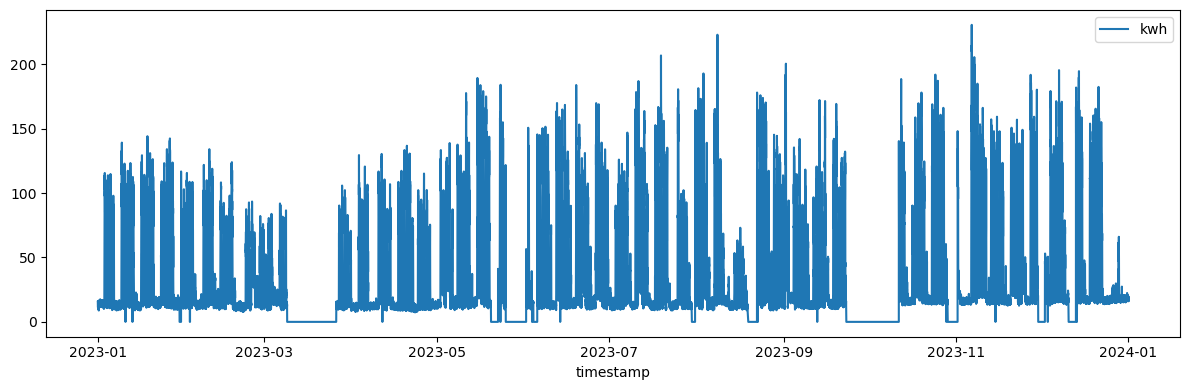

In [7]:
# Configura el tamaño de la figura antes de trazar
plt.figure(figsize=(12, 4))

# Trazar la línea usando sns.lineplot
sns.lineplot(data=building_11a)

# Ajustar el diseño para evitar que los elementos se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [9]:
building_11a_daily=building_11a.resample("D").sum()

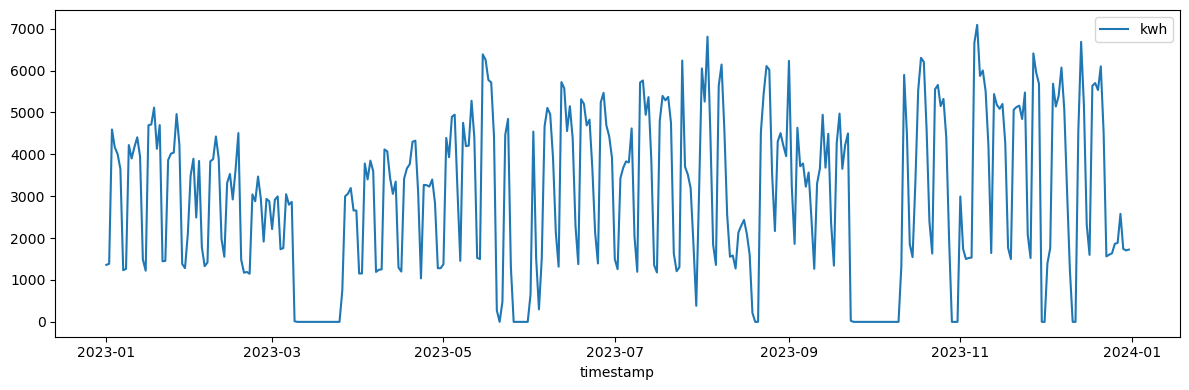

In [10]:
# Configura el tamaño de la figura antes de trazar
plt.figure(figsize=(12, 4))

# Trazar la línea usando sns.lineplot
sns.lineplot(data=building_11a_daily)

# Ajustar el diseño para evitar que los elementos se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Prueba de estacionaridad

In [11]:
from statsmodels.tsa.stattools import adfuller

# Prueba de estacionariedad usando ADF (Dickey-Fuller Aumentada)
adf_result = adfuller(building_11a_daily['kwh'].dropna())

# Extraer resultados de la prueba ADF
adf_output = {
    'ADF Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Critical Values': adf_result[4]
}
adf_output


{'ADF Statistic': np.float64(-4.2090237392352385),
 'p-value': np.float64(0.0006361048739635181),
 'Critical Values': {'1%': np.float64(-3.449226932880019),
  '5%': np.float64(-2.869857365438656),
  '10%': np.float64(-2.571201085130664)}}

Dado que el p-valor es menor que 0.05 y el estadístico ADF es más bajo que los valores críticos, rechazamos la hipótesis nula de no estacionariedad. Esto significa que la serie es estacionaria en su forma actual y no requiere diferenciación adicional.


## Análisis ACF y PACF

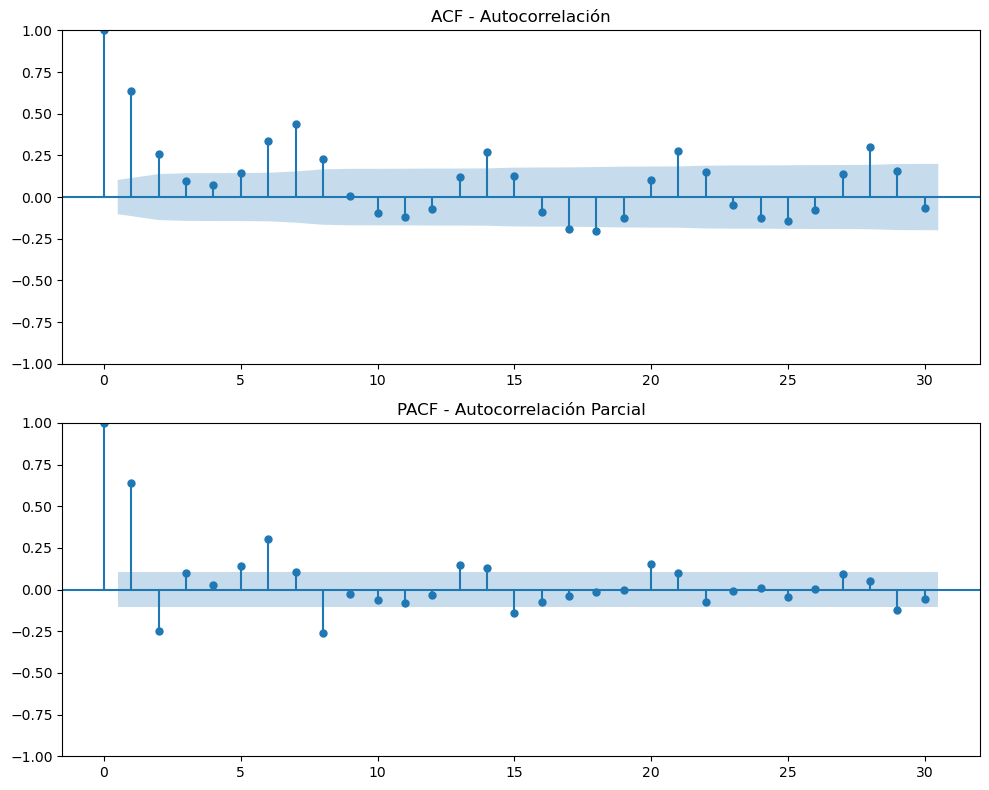

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Función de autocorrelación
plot_acf(building_11a_daily['kwh'], lags=30, ax=ax[0], title="ACF - Autocorrelación")

# Función de autocorrelación parcial
plot_pacf(building_11a_daily['kwh'], lags=30, ax=ax[1], title="PACF - Autocorrelación Parcial", method='ywm')

plt.tight_layout()
plt.show()


Análisis ACF y PACF:

ACF: Se observan picos significativos en los primeros lags y en el lag 7, lo que confirma un componente estacional semanal.

PACF: Muestra algunos picos en los lags iniciales, lo que sugiere un componente autorregresivo.

## Forcasting

SARIMA (Seasonal ARIMA): Este modelo es ideal si encontramos estacionalidad y tendencias. La estructura del modelo se adapta a datos con periodicidad, que es común en series de tiempo horarias y diarias.

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMA con los parámetros identificados
model_daily = SARIMAX(building_11a_daily['kwh'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
model_fit_daily = model_daily.fit(disp=False)

# Mostrar el resumen del modelo ajustado
model_summary_daily = model_fit_daily.summary()
model_summary_daily



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               kwh   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -3108.596
Date:                           Tue, 17 Dec 2024   AIC                           6227.192
Time:                                   02:11:12   BIC                           6246.692
Sample:                               01-01-2023   HQIC                          6234.942
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6972      0.054     12.800      0.000       0.590       0.804
ma.L1          0.0544      0.076      0.717      0.473      -0.094       0.203
ar.S.L7        1.0000      0.000   5150.394      0.000       1.000       1.000
ma.S.L7       -0.9961      0.059    -16.908      0.000      -1.112      -0.881
sigma2      1.353e+06   4.01e-08   3.38e+13      0.000    1.35e+06    1.35e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                51.65
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+28. Standard errors may be unstable.
"""

El modelo SARIMA(1, 0, 1)x(1, 0, 1, 7) captura tanto la estacionalidad semanal como los componentes no estacionales.
Aunque el coeficiente MA.L1 no es significativo, el resto de los parámetros son adecuados.
Las pruebas de diagnóstico indican que los residuales no tienen autocorrelación, lo cual es positivo.

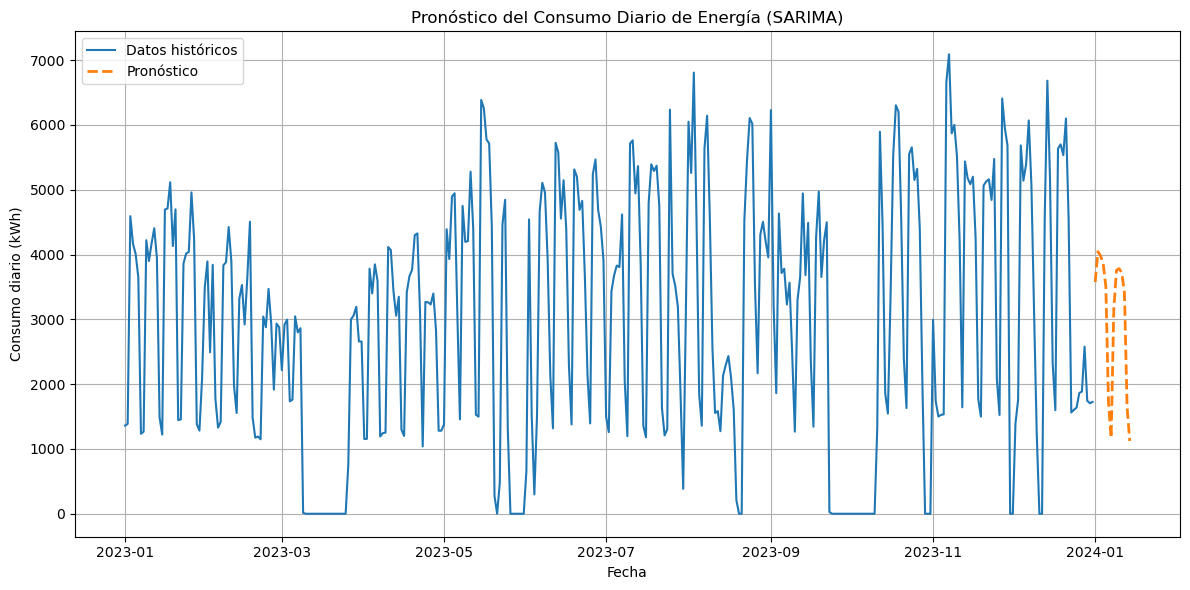

In [14]:
import matplotlib.pyplot as plt

# Realizar pronóstico para las próximas 14 días
forecast_steps_daily = 14
forecast_daily = model_fit_daily.forecast(steps=forecast_steps_daily)

# Crear una nueva serie temporal para el pronóstico
forecast_index_daily = pd.date_range(start=building_11a_daily.index[-1], periods=forecast_steps_daily + 1, freq='D')[1:]
forecast_series_daily = pd.Series(forecast_daily, index=forecast_index_daily)

# Graficar el pronóstico junto con los datos históricos
plt.figure(figsize=(12, 6))
plt.plot(building_11a_daily.index, building_11a_daily['kwh'], label='Datos históricos')
plt.plot(forecast_series_daily.index, forecast_series_daily, label='Pronóstico', linestyle='--', linewidth=2)
plt.title('Pronóstico del Consumo Diario de Energía (SARIMA)')
plt.xlabel('Fecha')
plt.ylabel('Consumo diario (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Separar datos para validación (últimos 7 días)
train = building_11a_daily['kwh'][:-14]
test = building_11a_daily['kwh'][-14:]

# Reajustar modelo solo con datos de entrenamiento
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
model_fit = model.fit(disp=False)

# Realizar pronóstico
forecast = model_fit.forecast(steps=len(test))


In [16]:
# Calcular métricas de error
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
smape_score=smape(test, forecast)


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"sMAPE: {smape_score:.2f}")

MAE: 1299.96
RMSE: 1480.69
sMAPE: 0.41


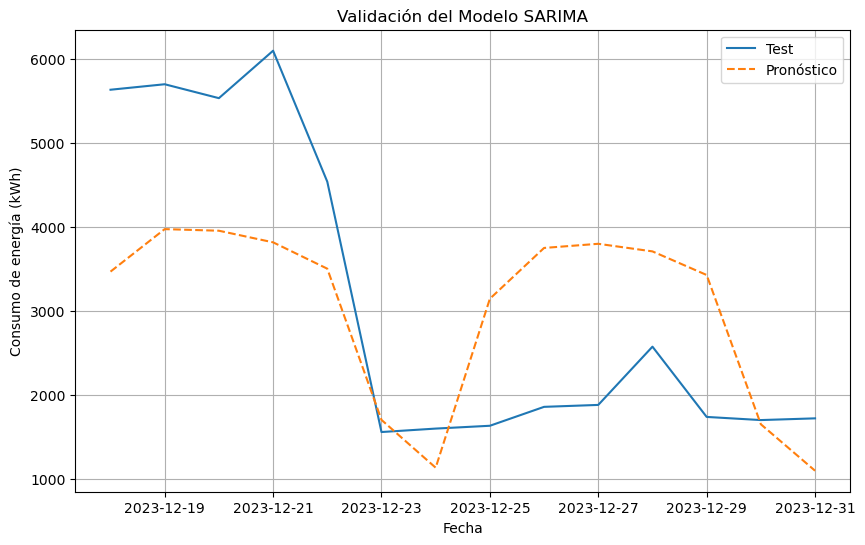

In [17]:
# Graficar el ajuste
plt.figure(figsize=(10, 6))
#plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Pronóstico', linestyle='--')
plt.title('Validación del Modelo SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Consumo de energía (kWh)')
plt.legend()
plt.grid(True)
plt.show()